Parte 3
===

In [1]:
import warnings as ws
ws.filterwarnings("ignore")

import pickle
import numpy as np
import pandas as pd
pd.set_option('float_format', '{:,.2f}'.format)

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

## 1. Carga de la base de datos

In [2]:
df = pd.read_csv('data/result.csv', sep=";", encoding='utf-8')

df.shape

(49175, 14)

In [3]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Creditos,"49,175.00",1.64,1.19,1.00,1.00,1.00,2.00,26.00
saldo_actual,"49,175.00","33,710,325.34","68,336,864.10","4,500,000.00","7,863,500.00","16,843,000.00","39,381,500.00","6,082,201,976.00"
saldo_vencido,"49,175.00","3,202,049.68","16,762,885.98",0.00,0.00,0.00,0.00,"1,608,429,952.00"
Promedio de limite_credito,"49,175.00","1,031,109.77","3,531,293.81",0.00,0.00,0.00,0.00,"101,900,000.00"
Promedio de credito_maximo,"49,175.00","18,864,845.65","23,789,915.44",0.00,"6,233,333.33","11,666,666.67","24,000,000.00","835,961,274.91"
Promedio de cantidad_cuotas,"49,175.00",62.90,55.15,0.00,30.00,60.00,78.00,592.00
Promedio de valor_cuota,"49,175.00","1,562,227.66","5,817,381.15",0.00,"250,000.00","404,333.33","746,500.00","339,129,984.00"
coaching_impacto,"49,175.00",0.00,0.07,0.00,0.00,0.00,0.00,1.00
Comunicaciones_saldo_actual,"49,175.00",975.17,"77,557.96",0.00,0.00,0.00,0.00,"7,896,000.00"
Comunicaciones_pagos_vencidos,"49,175.00",0.00,0.13,0.00,0.00,0.00,0.00,14.00


Luego de un pequeño análisis exploratorio, concluímos que estas variables son propicias para realizar la segmentación de usuarios. 

## 2. Segmentación de usuarios

Para realizar la segmentación de usuarios tenemos diferentes posibilidades de metodologías. Para efecto de este trabajo usaremos únicamente **KMeans** y realizaremos un ajuste basado en el **método del codo** para seleccionar una cantidad de grupos o segmentos apropiados para el problema.

In [4]:
# Eliminamos la variable objetivo ya que no aporta en la segmentación
group_df = df.copy()
# group_df = df[df.outlier == 0].copy().drop(columns='outlier')
# group_high_df = df[df.outlier == 1].copy().drop(columns='outlier')
# group_high_df['cluster'] = -1

# Dejemos escalados los datos para el modelado de Clustering
# scaler, columns = MinMaxScaler(), group_df.columns
# group_scaled_df = pd.DataFrame(scaler.fit_transform(group_df), columns=columns)

# group_high_df.shape, group_df.shape, group_scaled_df.shape
group_df.shape #, group_scaled_df.shape

(49175, 14)

### Selección cantidad de segmentos

Vamos a ejecutar el método KMeans de forma iterativa para diferentes tamaños de cluster, desde 1 hasta 9. Luego, vamos a graficar y validar en que cantidad de cluster se comporta mejor.

In [5]:
def run_clustering_range(X, lower=1, upper=10):
    distortions = []
    range_ = range(lower, upper)
    for k in range_:
        model = KMeans(n_clusters=k, random_state=0)
        model.fit(X)
        distortions.append(model.inertia_)
    return distortions, range_

def show_clustering_elbow(distortions, range_):
    plt.figure(figsize=(12, 8))
    plt.plot(range_, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

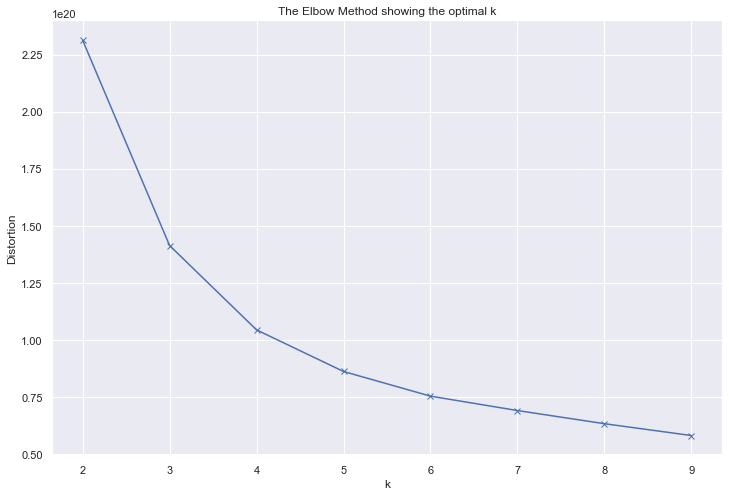

In [6]:
distortions, range_ = run_clustering_range(group_df, 2, 10)
show_clustering_elbow(distortions, range_)

Notese que el codo más pronunciado esta en 3 clusters, pero se presenta un debate entre usar 3 o 4 clusters. Vamos a decidir usando las métricas de evaluación **Silhouette Coefficient**.

In [7]:
for k in [3, 4]:
    model_ = KMeans(n_clusters=k, random_state=0).fit(group_df)
    print(f"Entrenamiento completado para {k} clusters")
    print(f"Silhouette coefficient para {k} clusters: {silhouette_score(group_df, model_.labels_, metric='euclidean')}")

Entrenamiento completado para 3 clusters
Silhouette coefficient para 3 clusters: 0.7653551398777098
Entrenamiento completado para 4 clusters
Silhouette coefficient para 4 clusters: 0.6344619004552084


Dado el resultado anterior la cantidad correcta de clusters es **3**.

In [16]:
cluster_count = 3

model_final = KMeans(n_clusters=cluster_count, random_state=0)
model_final.fit(group_df)

pd.Series(model_final.labels_).value_counts()

0    46402
2     2769
1        4
dtype: int64

Notese que tenemos un cluster con 4 usuarios. Vamos a evaluar los datos de este cluster y graficar todos los clusters juntos para visualizar separación de los grupos y posibles insights para etiquetado de los mismos a nivel de negocio.

In [26]:
# Re-etiquetamos los cluster, considerando que el cluster 0 será el de mayor cantidad de usuarios
cluster_config = dict(zip(pd.Series(model_final.labels_).value_counts().index, list(range(0, cluster_count))))
cluster_labels = np.array([cluster_config[i] for i in model_final.labels_])

grouped_df = group_df.copy()
grouped_df['cluster'] = cluster_labels

# grouped_scaled_df = group_scaled_df.copy()
# grouped_scaled_df['cluster'] = model_final.labels_

### Evaluación del modelo seleccionado

<AxesSubplot:title={'center':'Flattened Graph of KMeans(n_clusters=3, random_state=0) model'}>

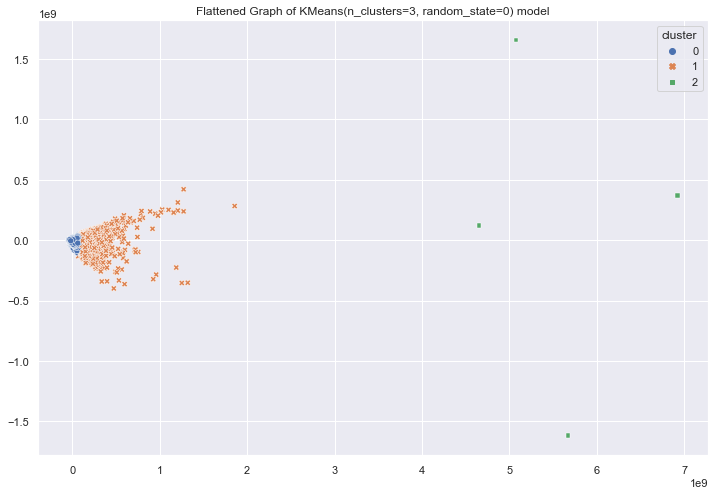

In [27]:
transformed = PCA(n_components=2, random_state=1).fit_transform(grouped_df)

plt.figure(figsize=(12, 8))
plt.title(f'Flattened Graph of {str(model_final)} model')
sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=grouped_df.cluster, 
                style=grouped_df.cluster, palette='deep')

Visualmente podemos notar que el **cluster 2** presenta unos datos bastante alejados de los otros grupos. Visualizamos nuevamente pero los otros dos cluster.

<AxesSubplot:title={'center':'Flattened Graph of KMeans(n_clusters=3, random_state=0) model'}>

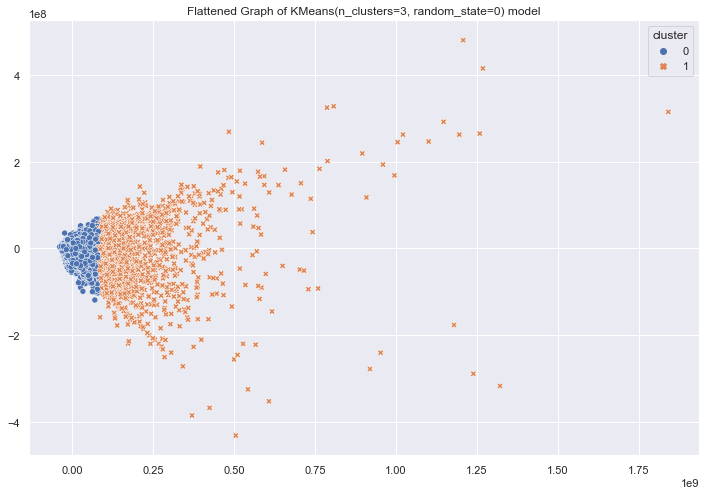

In [28]:
temp_grouped_df = grouped_df[grouped_df.cluster != 2]

transformed_ = PCA(n_components=2, random_state=1).fit_transform(temp_grouped_df)

plt.figure(figsize=(12, 8))
plt.title(f'Flattened Graph of {str(model_final)} model')
sns.scatterplot(x=transformed_[:,0], y=transformed_[:,1], hue=temp_grouped_df.cluster, 
                style=temp_grouped_df.cluster, palette='deep')

En esta gráfica podemos notar bien definidos el **cluster 0 y 1**. Vamos a analizar un poco la composición de cada cluster en términos de los datos para etiquetarlos y poder definir estrategías.

Lo primero que haremos es separar el **cluster 2** de todo el conjunto, no sin antes determinar una etiqueta correcta para este grupo de usuarios, que sirva para plantear estrategías de comunicación.

In [29]:
grouped_df[grouped_df.cluster == 2].transpose()

,12289,14994,25719,26648
Creditos,11.00,8.00,11.00,20.00
saldo_actual,"5,791,003,096.00","3,808,950,064.00","6,082,201,976.00","4,264,518,048.00"
saldo_vencido,"1,608,429,952.00",0.00,0.00,0.00
Promedio de limite_credito,0.00,"4,476,250.00","22,000,000.00","80,000,000.00"
Promedio de credito_maximo,"835,961,274.91","471,296,008.00","828,251,895.20","303,669,210.95"
Promedio de cantidad_cuotas,58.00,17.00,92.00,52.00
Promedio de valor_cuota,"100,060,364.91","72,885,876.00","20,274,272.73","8,126,550.00"
coaching_impacto,0.00,0.00,0.00,0.00
Comunicaciones_saldo_actual,0.00,0.00,0.00,0.00
Comunicaciones_pagos_vencidos,0.00,0.00,0.00,0.00


In [30]:
grouped_df[grouped_df.cluster == 2].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Creditos,4.00,12.50,5.20,8.00,10.25,11.00,13.25,20.00
saldo_actual,4.00,"4,986,668,296.00","1,118,878,862.85","3,808,950,064.00","4,150,626,052.00","5,027,760,572.00","5,863,802,816.00","6,082,201,976.00"
saldo_vencido,4.00,"402,107,488.00","804,214,976.00",0.00,0.00,0.00,"402,107,488.00","1,608,429,952.00"
Promedio de limite_credito,4.00,"26,619,062.50","36,831,774.60",0.00,"3,357,187.50","13,238,125.00","36,500,000.00","80,000,000.00"
Promedio de credito_maximo,4.00,"609,794,597.26","265,687,516.00","303,669,210.95","429,389,308.74","649,773,951.60","830,179,240.13","835,961,274.91"
Promedio de cantidad_cuotas,4.00,54.75,30.72,17.00,43.25,55.00,66.50,92.00
Promedio de valor_cuota,4.00,"50,336,765.91","43,460,152.20","8,126,550.00","17,237,342.05","46,580,074.36","79,679,498.23","100,060,364.91"
coaching_impacto,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Comunicaciones_saldo_actual,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Comunicaciones_pagos_vencidos,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


Notese como en el **cluster 2** tenemos solo 4 usuarios. Estos tienen los valores más altos de **saldo_actual**, **saldo_vencido**, **Promedio de credito_maximo**, **Promedio de valor_cuota** y **Consumo_saldo_actual**. Esto significa que puede tratarse de grandes clientes empresariales que tienen valores de préstamos o servicios de grandes sumas de dinero.

La variable **Consumo_saldo_actual** esta relacionada con el producto **Crédito de Consumo**. Podemos notar como este valor incide muy fuerte sobre **saldo_actual**, es decir, la suma consolidada de todos los compromisos.

Vamos a etiquetar este cluster como: **Grandes Cuentas**.

In [31]:
grouped_df['cluster'] = grouped_df.cluster.apply(
    lambda x: 'Grandes Cuentas' if x == 2 else x
)

grouped_df.cluster.value_counts()

0                  46402
1                   2769
Grandes Cuentas        4
Name: cluster, dtype: int64

Ahora, continuemos el análisis pero únicamente con el **cluster 0 y 1**

In [32]:
grouped_temp_df = grouped_df[grouped_df.cluster.isin([0, 1])]
grouped_temp_df.cluster.value_counts()

0    46402
1     2769
Name: cluster, dtype: int64

In [33]:
aggregate_dict = dict(zip(grouped_temp_df.columns[:-1], [['count', 'min', 'mean', 'max'] for i in grouped_temp_df.columns[:-1]]))

grouped_temp_df.groupby('cluster').agg(aggregate_dict).transpose()

cluster                                          0                1
Creditos                      count      46,402.00         2,769.00
                              min             1.00             1.00
                              mean            1.50             3.97
                              max            10.00            26.00
saldo_actual                  count      46,402.00         2,769.00
                              min     4,500,000.00    66,968,000.00
                              mean   24,470,340.27   181,396,116.37
                              max   138,469,000.00 1,597,282,024.00
saldo_vencido                 count      46,402.00         2,769.00
                              min             0.00             0.00
                              mean    2,516,414.87    14,115,449.64
                              max   226,550,000.00   865,009,024.00
Promedio de limite_credito    count      46,402.00         2,769.00
                              min             0.00             0.00
                              mean      899,334.88     3,202,386.97
                              max    90,000,000.00   101,900,000.00
Promedio de credito_maximo    count      46,402.00         2,769.00
                              min             0.00             0.00
                              mean   16,020,166.66    65,681,413.03
                              max   198,000,000.00   585,000,000.00
Promedio de cantidad_cuotas   count      46,402.00         2,769.00
                              min             0.00             0.00
                              mean           60.87            96.80
                              max           592.00           363.00
Promedio de valor_cuota       count      46,402.00         2,769.00
                              min             0.00             0.00
                              mean    1,417,312.21     3,920,215.65
                              max   134,928,000.00   339,129,984.00
coaching_impacto              count      46,402.00         2,769.00
                              min             0.00             0.00
                              mean            0.00             0.01
                              max             1.00             1.00
Comunicaciones_saldo_actual   count      46,402.00         2,769.00
                              min             0.00             0.00
                              mean        1,033.45             0.00
                              max     7,896,000.00             0.00
Comunicaciones_pagos_vencidos count      46,402.00         2,769.00
                              min             0.00             0.00
                              mean            0.00             0.00
                              max            14.00             0.00
Consumo_saldo_actual          count      46,402.00         2,769.00
                              min             0.00             0.00
                              mean   12,384,600.00    97,200,167.23
                              max    89,507,000.00 1,067,885,024.00
perfil_usuario_Alto           count      46,402.00         2,769.00
                              min             0.00             0.00
                              mean            0.31             0.37
                              max             1.00             1.00
perfil_usuario_Joven          count      46,402.00         2,769.00
                              min             0.00             0.00
                              mean            0.00             0.00
                              max             1.00             0.00
perfil_usuario_Sin registro   count      46,402.00         2,769.00
                              min             0.00             0.00
                              mean            0.35             0.39
                              max             1.00             1.00

Analizando cada una de las variables, sus valores promedio, mínimo y máximo, podemos intuir que el **cluster 0** agrupa usuarios que tienen valores más pequeños en sus compromisos financieros. Por otro lado, los usuarios del **cluster 1** tienen valores intermedios. 

Las variables que más aportan a esta determinanción son: **Creditos, saldo_actual, saldo_vencido, Promedio de credito_maximo, Promedio de valor_cuota, Consumo_saldo_actual.** El resto no tienen tanta influencia.

Vamos a graficar estas variables y confirmar visualmente las suposiciones anteriores.

<AxesSubplot:xlabel='saldo_actual', ylabel='saldo_vencido'>

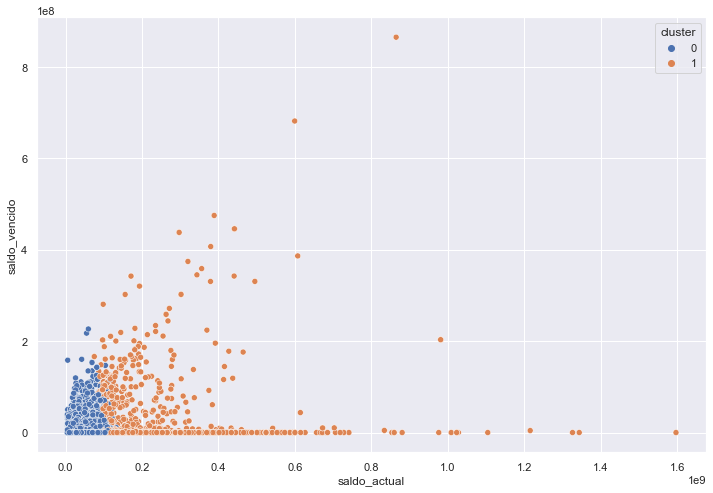

In [34]:
f, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=grouped_temp_df, x="saldo_actual", y="saldo_vencido", hue="cluster")

<AxesSubplot:xlabel='saldo_actual', ylabel='Promedio de credito_maximo'>

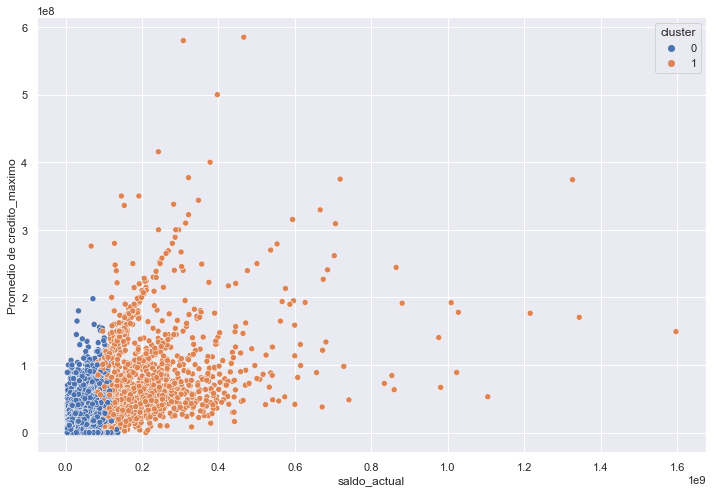

In [36]:
f, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=grouped_temp_df, x="saldo_actual", y="Promedio de credito_maximo", hue="cluster")

<AxesSubplot:xlabel='saldo_actual', ylabel='Promedio de valor_cuota'>

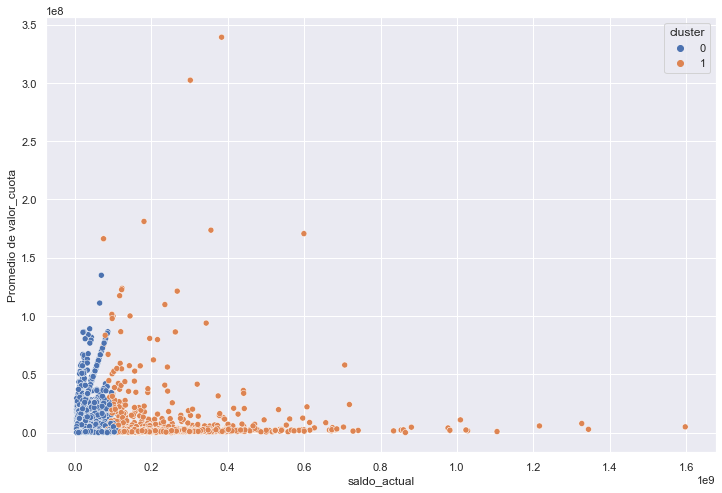

In [37]:
f, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=grouped_temp_df, x="saldo_actual", y="Promedio de valor_cuota", hue="cluster")

<AxesSubplot:xlabel='saldo_actual', ylabel='Consumo_saldo_actual'>

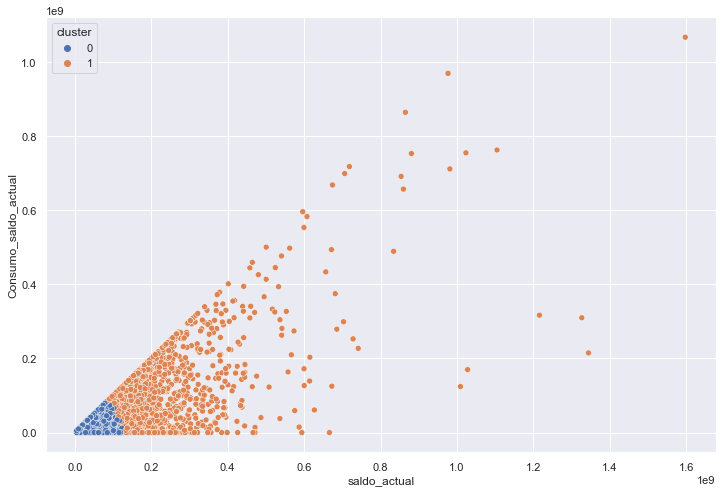

In [38]:
f, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=grouped_temp_df, x="saldo_actual", y="Consumo_saldo_actual", hue="cluster")

<AxesSubplot:xlabel='Promedio de credito_maximo', ylabel='Consumo_saldo_actual'>

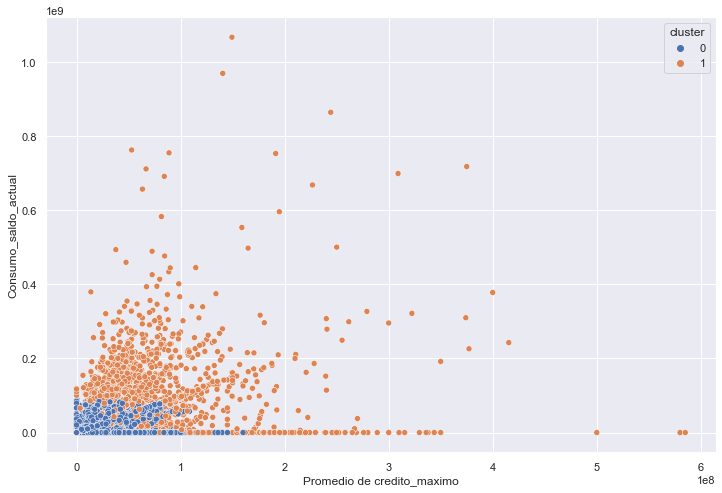

In [39]:
f, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=grouped_temp_df, x="Promedio de credito_maximo", y="Consumo_saldo_actual", hue="cluster")

Las gráficas y resumenes anteriores nos permitir confirmar que el **cluster 0** hace referencia a usuarios con carteras más pequeñas. Puede tratarse de personas naturales con una cantidad baja de créditos (el valor promedio es 1.5). Vamos a clasificar este grupo con la etiquetas: **Cuentas Persona Natural**.

Por otro lado, el **cluster 1** tiene usuarios efectivamente con una cantidad de productos intermedia (valor promedio 3.97) y se puede notar visualmente, que los saldos y valores promedio de crédito máximo y valor cuota son más altos que el cluster 0. Se trata de personas que mueven más vólumen, quizás pequeñas empresas o independientes que realizan transacciones más grandes. Vamos a etiquetar este grupo como **Cuentas Pequeños Negocios**.

In [40]:
grouped_df['cluster'] = grouped_df.cluster.apply(
    lambda x: 'Cuentas Persona Natural' if x == 0 else x
)
grouped_df['cluster'] = grouped_df.cluster.apply(
    lambda x: 'Cuentas Pequeños Negocios' if x == 1 else x
)

grouped_df.cluster.value_counts()

Cuentas Persona Natural      46402
Cuentas Pequeños Negocios     2769
Grandes Cuentas                  4
Name: cluster, dtype: int64

## 3. Estrategías de marketing por segmento

**Cuentas Persona Natural**: 
> *Estimado (nombre del cliente). ¿Necesitas ponerte al día con tus pagos y aún no puedes? Recueda que tu bienestar financiero es importante para nosotros y podemos ayudarte a normalizar tus deudas, solo debes ingresar a este [enlace](enlace) y encontrarás más detalles*

**Cuentas Pequeños Negocios**: 
> *Estimado (nombre del cliente). ¿Has tenido dificultades para el pago de tus deudas? ¿Necesitas un salvavidas justo ahora? Tu bienestar es importante para nosotros  y podemos ayudarte a normalizar tus compromisos, solo debes ingresar a este [enlace](enlace) y encontrarás más detalles*

**Grandes Cuentas**: 
> *Estimado (nombre del cliente). ¿Necesitas algún tipo de alivio financiero en este momento? Eres uno de nuestros clientes VIP y tenemos un paquete de beneficios para normalizar tus deudas, solo debes ingresar a este [enlace](enlace) y encontrarás más detalles*